In [37]:
from langchain.chains.conversational_retrieval.base import ConversationalRetrievalChain
from langchain.chat_models import init_chat_model
from langchain.memory import ConversationBufferMemory
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import create_retriever_tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

from applications.export_report.graph import load_excel_and_convert_to_documents
from graph import build_graph
import os, getpass
import pandas as pd

In [2]:
graph_report = build_graph()

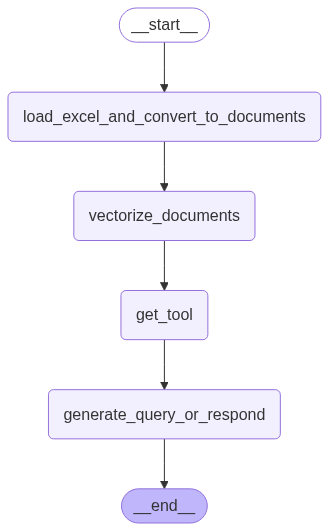

In [3]:
graph_report

In [2]:
with open("../../resources/Out_9.xlsx", "rb") as f:
    excel_bytes = f.read()

inputs = {
    "excel_file": excel_bytes,
    "prompt": "Summarize the excel file"
}

In [4]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

NameError: name 'os' is not defined

In [7]:
graph_report.invoke(inputs)

/Users/huytq1/Documents/tech-by-me/core-ai/applications/export_report/graph.py:23: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  df = pd.read_excel(state["excel_file"])


KeyboardInterrupt: 

In [13]:
df = pd.read_excel(excel_bytes)

chunks = []
for idx, row in df.iterrows():
    row_text = ", ".join([f"{col}: {row[col]}" for col in df.columns])
    chunks.append(row_text)

docs = [Document(page_content=chunk) for chunk in chunks]

/var/folders/dk/8plcwpv53gg0_dg9fkx_rgr00000gn/T/ipykernel_8990/663948984.py:1: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  df = pd.read_excel(excel_bytes)


In [16]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)
embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(split_docs, embedding=embeddings)

In [18]:
retriever = vectorstore.as_retriever()
retriever_tool = create_retriever_tool(
        retriever,
        "retrieve_documents",
        "Search and return information documents",
    )

In [25]:
retriever_tool.invoke("summarize the data of Canada")

'Unnamed: 0: 251, country: Canada, continent: Americas, year: 2007, lifeExp: 80.653, pop: 33390141, gdpPercap: 36319.23501, iso_alpha: CAN, iso_num: 124\n\nUnnamed: 0: 251, country: Canada, continent: Americas, year: 2007, lifeExp: 80.653, pop: 33390141, gdpPercap: 36319.23501, iso_alpha: CAN, iso_num: 124\n\nUnnamed: 0: 251, country: Canada, continent: Americas, year: 2007, lifeExp: 80.653, pop: 33390141, gdpPercap: 36319.23501, iso_alpha: CAN, iso_num: 124\n\nUnnamed: 0: 243, country: Canada, continent: Americas, year: 1967, lifeExp: 72.13, pop: 20819767, gdpPercap: 16076.58803, iso_alpha: CAN, iso_num: 124'

In [38]:
llm = init_chat_model(temperature=0, model='openai:gpt-4o-mini')
custom_prompt = ChatPromptTemplate.from_template(
        """You acting as a professional data analyst.
        Based on the provided data set, perform in-depth analysis and evaluation.
        Focus on making valuable comparisons, important statistics (such as min, max, average),
        and potential relationships between elements in the data.
        The goal is to help readers understand the big picture, detect trends, anomalies,
        or actionable insights, and suggest appropriate visual charts to effectively present the information.

        {context}

        Question: {question}
        """
    )
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversation = ConversationalRetrievalChain.from_llm(
            llm=llm,
    memory=memory,
            retriever=retriever,
            combine_docs_chain_kwargs={"prompt": custom_prompt},
        )

/var/folders/dk/8plcwpv53gg0_dg9fkx_rgr00000gn/T/ipykernel_8990/1057880871.py:15: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


In [40]:
import json

response = conversation.invoke({"question": "summarize the data of Canada"})
with open('canada_summary.md', 'w') as f:
    f.write(response['answer'])


In [1]:
from graph import init_graph_agent
graph_agent = init_graph_agent(retriever_tool)
graph_agent

NameError: name 'retriever_tool' is not defined